In [7]:
from utils import *
from args import *
from model import *

class Args:
    def __init__(self):
        self.dataset = "Douban"
        self.ratio = 0.2
        self.use_attr = True
        self.distance = "rwr"
        self.device = "cpu"
        self.use_gcn = False
        self.num_gcn_layers = 1

args = Args()

# check compatibility between dataset and use_attr
if args.dataset == 'noisy-cora1-cora2':
    assert args.use_attr is True, 'noisy-cora1-cora2 requires using node attributes'
elif args.dataset == 'foursquare-twitter':
    assert args.use_attr is False, 'foursquare-twitter does not have node attributes'

# load data and build networkx graphs
print("Loading data...")
edge_index1, edge_index2, x1, x2, anchor_links, test_pairs = load_data(f"datasets/{args.dataset}", args.ratio, args.use_attr)
G1, G2 = build_nx_graph(edge_index1, x1), build_nx_graph(edge_index2, x2)
num_anchor_links = anchor_links.shape[0]

# compute distance metric scores (e.g. random walk with restart (rwr))
dists_score1, dists_score2 = get_distance_matrix(G1, G2, anchor_links, args.dataset, args.ratio, args.distance)

# device setting
assert torch.cuda.is_available() or args.device == 'cpu', 'CUDA is not available'
device = torch.device(args.device)

# build PyG Data objects
G1_data = build_tg_graph(G1.number_of_nodes(), edge_index1, x1, anchor_links[:, 0], dists_score1).to(device)
G2_data = build_tg_graph(G2.number_of_nodes(), edge_index2, x2, anchor_links[:, 1], dists_score2).to(device)
if args.use_gcn:
    gcn_output = np.load(f'gcn_out/{args.dataset}_gcn_results_{args.num_gcn_layers}_layers.npz')
    G1_data.x = torch.tensor(gcn_output['x1'], dtype=torch.float).to(device)
    G2_data.x = torch.tensor(gcn_output['x2'], dtype=torch.float).to(device)

Loading data...
Loading rwr scores from datasets/rwr/rwr_emb_Douban_0.2.npz... Done


In [8]:
r1, r2 = G1_data.dists, G2_data.dists
x1, x2 = G1_data.x, G2_data.x
r1, r2 = F.normalize(r1, p=2, dim=1), F.normalize(r2, p=2, dim=1)
x1, x2 = F.normalize(x1, p=2, dim=1), F.normalize(x2, p=2, dim=1)

In [10]:
dist_r_exp = torch.exp(-(r1 @ r2.T))
dist_x_exp = torch.exp(-(x1 @ x2.T))
print(dist_r_exp)
print(dist_x_exp)

tensor([[0.9615, 0.9276, 0.9684,  ..., 0.9897, 0.9906, 0.9241],
        [0.9702, 0.8998, 0.9777,  ..., 0.9823, 0.9828, 0.9218],
        [0.9783, 0.9079, 0.8637,  ..., 0.9776, 0.9660, 0.8861],
        ...,
        [0.9886, 0.9212, 0.9533,  ..., 0.9876, 0.9894, 0.8910],
        [0.9786, 0.9189, 0.9786,  ..., 0.9773, 0.9803, 0.8963],
        [0.9937, 0.9869, 0.9955,  ..., 0.9962, 0.9971, 0.9836]])
tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.3679, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.3679, 1.0000],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.3679, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]])


In [11]:
import matplotlib.pyplot as plt

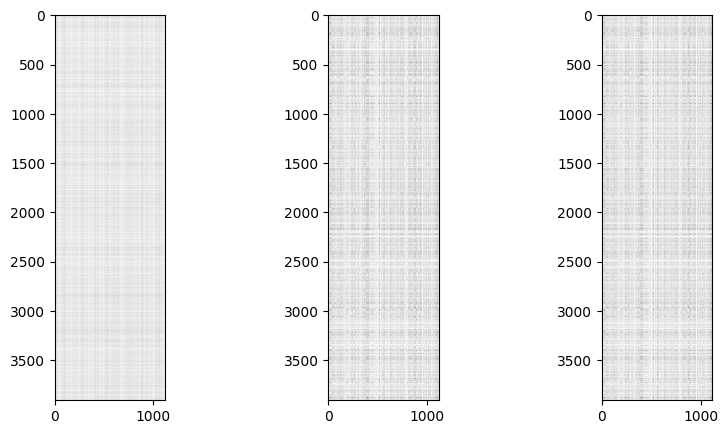

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow(dist_r_exp, cmap='gray')
axs[1].imshow(dist_x_exp, cmap='gray')
axs[2].imshow(0.05 * dist_r_exp + 0.95 + dist_x_exp, cmap='gray')